In [ ]:
%%capture
#@title Setup Environment
# Install the latest Tensorflow version.
!pip3 install tensorflow_text
!pip3 install --upgrade tensorflow-gpu
!pip install tensorflow-hub
!pip install bokeh
!pip install simpleneighbors
!pip install tqdm

import seaborn as sns

import bokeh
import bokeh.models
import bokeh.plotting

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:

def visualize_similarity(embeddings_1, embeddings_2, labels_1, labels_2,
                         plot_title,
                         plot_width=1200, plot_height=600,
                         xaxis_font_size='12pt', yaxis_font_size='12pt'):

  assert len(embeddings_1) == len(labels_1)
  assert len(embeddings_2) == len(labels_2)

  # arccos based text similarity (Yang et al. 2019; Cer et al. 2019)
  sim = 1 - np.arccos(
      sklearn.metrics.pairwise.cosine_similarity(embeddings_1,
                                                 embeddings_2))/np.pi

  embeddings_1_col, embeddings_2_col, sim_col = [], [], []
  for i in range(len(embeddings_1)):
    for j in range(len(embeddings_2)):
      embeddings_1_col.append(labels_1[i])
      embeddings_2_col.append(labels_2[j])
      sim_col.append(sim[i][j])
  df = pd.DataFrame(zip(embeddings_1_col, embeddings_2_col, sim_col),
                    columns=['embeddings_1', 'embeddings_2', 'sim'])

  mapper = bokeh.models.LinearColorMapper(
      palette=[*reversed(bokeh.palettes.YlOrRd[9])], low=df.sim.min(),
      high=df.sim.max())

  p = bokeh.plotting.figure(title=plot_title, x_range=labels_1,
                            x_axis_location="above",
                            y_range=[*reversed(labels_2)],
                            plot_width=plot_width, plot_height=plot_height,
                            tools="save",toolbar_location='below', tooltips=[
                                ('pair', '@embeddings_1 ||| @embeddings_2'),
                                ('sim', '@sim')])
  p.rect(x="embeddings_1", y="embeddings_2", width=1, height=1, source=df,
         fill_color={'field': 'sim', 'transform': mapper}, line_color=None)

  p.title.text_font_size = '12pt'
  p.axis.axis_line_color = None
  p.axis.major_tick_line_color = None
  p.axis.major_label_standoff = 16
  p.xaxis.major_label_text_font_size = xaxis_font_size
  p.xaxis.major_label_orientation = 0.25 * np.pi
  p.yaxis.major_label_text_font_size = yaxis_font_size
  p.min_border_right = 300

  bokeh.io.output_notebook()
  bokeh.io.show(p)

In [ ]:

def vis_sim(etalon_l, answers_l, etalon_emb, answers_emb):

    answers_sim = [get_similarities(etalon_emb, [ans_emb]) for ans_emb in answers_emb]

    answers_sim = [list(map(lambda x: x[0][0], answers_sim))]

    fig, ax = plt.subplots(figsize=(10,6))
    sns.heatmap(answers_sim, center=0, annot=True, cbar=False)

    ax.set_yticklabels(["etalon"])
    ax.set_xticklabels(["%i answer" % (i+1) for i in range(len(answers_l))])

    print("etalon - %s" % etalon_l[0])
    for i in range(len(answers_l)):
        print("%i answer - %s" % (i+1, answers_l[i]))

    plt.show()

def get_embeddings(sequence):
    return embed_text(sequence)

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [11]:
def print_scores(scores_structure, file_name):
    features_names = [', '.join(x) for x in scores_structure[0]]
    features = list(range(len(scores_structure[0])))
    # plt.figure(figsize=(20,20))
    plt.figure(figsize=(20, 10))
    plt.rcParams.update({'font.size': 30})
    plt.bar(features, scores_structure[1], align='edge', width=0.3)
    plt.ylabel('score', fontsize=44)
    plt.xlabel('features', fontsize=44)
    file_prefix = '/home/droman/Documents/diploma/deeppavlov_ner_3.6/data/output/images/'
    plt.savefig(file_prefix + file_name+'.png')
    plt.show()
    lines = ""
    for i in range(len(features)):
        line = str(i) + " - " + features_names[i]
        lines += line + "\n"
    with open(file_prefix + file_name + ".txt", "w") as file:
        print(lines)
        file.write(lines)

def get_scores(input="/home/droman/Documents/diploma/deeppavlov_ner_3.6/data/output/classification/scores.json"):
    with open(input) as json_file:
        return json.load(json_file)


def most_scored():
    get_columns_from_json = lambda scores_data: scores_data["items"][0]["x_columns"]
    get_scores_from_json = lambda scores_data: scores_data["items"][0]["scores"]
    most_scored_abstract(get_columns_from_json, get_scores_from_json)

def less_scored():
    get_columns_from_json = lambda scores_data: scores_data["items"][0]["x_columns"]
    get_scores_from_json = lambda scores_data: scores_data["items"][0]["scores"]
    less_scored_abstract(get_columns_from_json, get_scores_from_json)

def most_scored_abstract(get_columns_from_json, get_scores_from_json):
    print_scored_abstract(lambda x: x[:5], get_columns_from_json, get_scores_from_json, "most_sorted")

def less_scored_abstract(get_columns_from_json, get_scores_from_json):
    print_scored_abstract(lambda x: x[-5:], get_columns_from_json, get_scores_from_json, "less_sorted")

def print_scored_abstract(get_part, get_columns_from_json, get_scores_from_json, file_name):
    scores_data = get_scores()

    columns = get_columns_from_json(scores_data)
    scores = get_scores_from_json(scores_data)

    pairs = []
    assert len(columns) == len(scores)
    for i in range(len(columns)):
        pairs.append([columns[i], scores[i]])

    sorted(pairs, key=lambda x: x[1])
    pairs = get_part(pairs)

    columns = [i[0] for i in pairs]
    scores = [i[1] for i in pairs]

    print_scores([columns, scores], file_name)

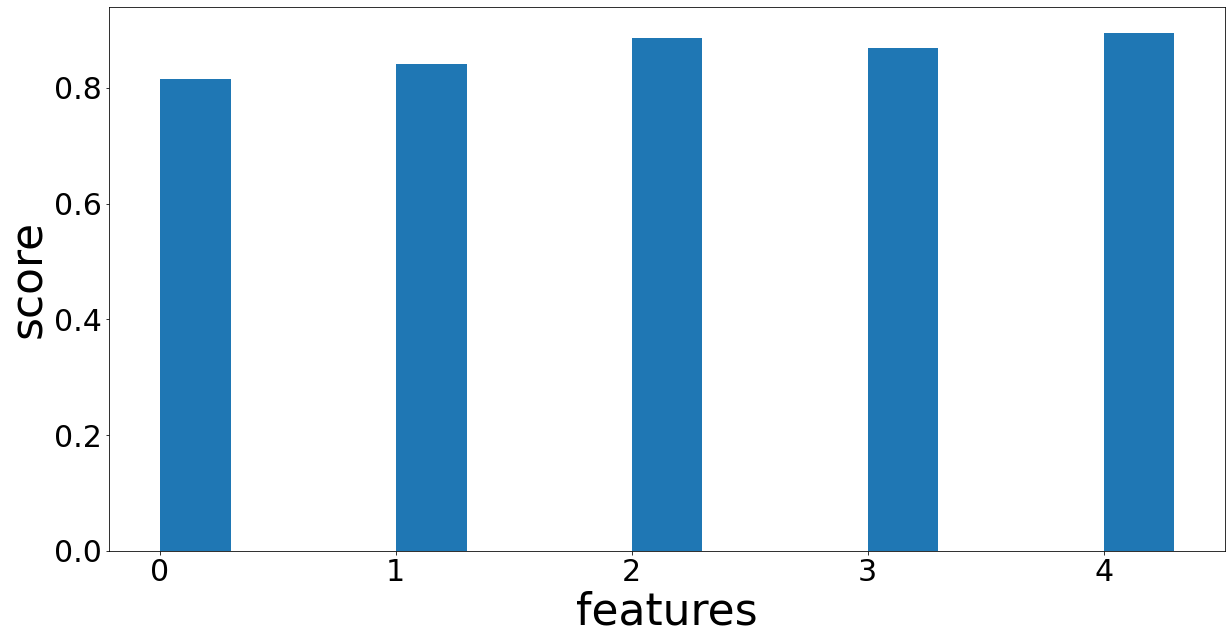

0 - tfidf_distance
1 - tfidf_distance, laser_distance
2 - tfidf_distance, laser_distance, use_distance
3 - tfidf_distance, laser_distance, use_distance, fasttext_distance
4 - tfidf_distance, laser_distance, use_distance, fasttext_distance, bert_distance



In [12]:
# less_scored()
most_scored()

In [ ]:
# вывести все
# топ лучший
# топ худших
# сравнить лучшие между разными данными
# сравнить худшие между разными данными
# сравнить один набор фич с разными типами данных, как будто по времени
# попробовать проанализировать вклад custom ner
# сравнить фичи по отдельности


